# Plot Time-Series-Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
# Set to Latex
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', serif='Computer Modern Roman')

In [3]:
df_area = pd.read_csv(r"load in the classified data", 
                      delimiter=',', 
                      parse_dates=['date'])

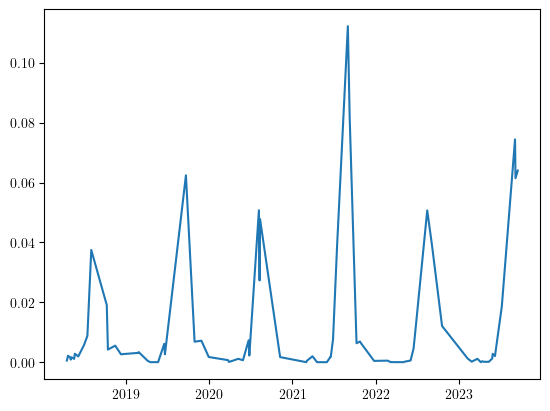

In [4]:
df_cart = df_area[df_area['classifier'] == 'cart'].copy()
df_rf = df_area[df_area['classifier'] == 'rf'].copy()
df_svm = df_area[df_area['classifier'] == 'svm'].copy()
df_knn = df_area[df_area['classifier'] == 'knn'].copy()
df_gbt = df_area[df_area['classifier'] == 'gbt'].copy()
df_cons = df_area[df_area['classifier'] == 'cons'].copy()
plt.plot(df_cons['date'], df_cons['class_2_perc'])

### Load and preprocess the data of the other time series variables

In [5]:
# Seagrass and green algae
df_sg = pd.read_excel(r"path_to_seagrass_polys")
df_ga = pd.read_excel(r"path_to_green_algae_data")
df_sg['date'] = pd.to_datetime(df_sg['date'])
df_ga['date'] = pd.to_datetime(df_ga['date'])

In [6]:
# storms
df_storm_1 = pd.read_excel(r"path_to_storm_data")
df_storm_2 = pd.read_excel(r"path_to_severe_storm_data")
df_storm_2['date'] = pd.to_datetime(df_storm_2['date'])
df_storm_1['date'] = pd.to_datetime(df_storm_1['date'])

In [7]:
print(df_storm_1.columns)
print(df_storm_2.columns)

Index(['date', 'storms'], dtype='object')
Index(['date', 'Severe', 'Very_Severe'], dtype='object')


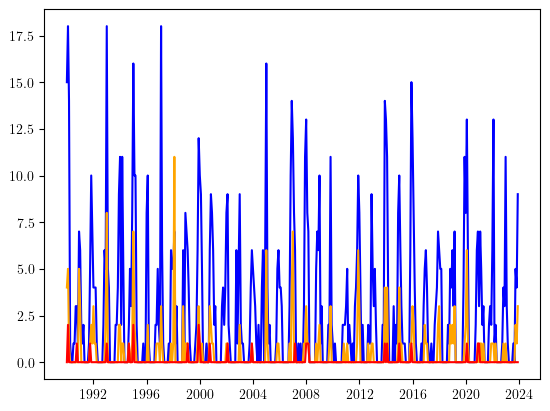

In [8]:
# plot the storms
plt.plot(df_storm_1['date'], df_storm_1['storms'], c='blue')
plt.plot(df_storm_2['date'], df_storm_2['Severe'], c='orange')
plt.plot(df_storm_2['date'], df_storm_2['Very_Severe'], c='red')

In [46]:
# satellite data for salinity, chlor-a and sea surface temperature
df_chlor_a_gcom = pd.read_csv(r"path_to_chlor_a_gcom", delimiter=',')
df_chlor_a_modis = pd.read_csv(r"path_to_chlor_a_modis", delimiter=',')
df_salinity_hycom = pd.read_csv(r"path_to_salinity_hycom", delimiter=',')
df_sst_modis = pd.read_csv(r"path_to_sst_modis", delimiter=',')
df_sst_hycom = pd.read_csv(r"path_to_sst_hycom", delimiter=',')
df_sst_noaa = pd.read_csv(r"path_to_sst_noaa", delimiter=',')
df_wv_hycom = pd.read_csv(r"path_to_wave_velocity_hycom", delimiter=',')

In [47]:
df_salinity_hycom['system:index'] = df_salinity_hycom['system:index'].astype(str)
df_sst_hycom['system:index'] = df_sst_hycom['system:index'].astype(str)
df_sst_noaa['system:index'] = df_sst_noaa['system:index'].astype(str)
df_wv_hycom['system:index'] = df_wv_hycom['system:index'].astype(str)

In [48]:
def prep_type1(df, line=''):
    if 'system:index' in df.columns:
        # Extrahiere das Datum
        df['date'] = df['system:index'].str.extract(r'_(\d{8})D')[0]
        df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='coerce')

        # Filtere nach Datum ab 2015
        df = df[df['date'] >= pd.Timestamp('1990-01-01')]

        # Kopiere die relevanten Spalten
        new_df = df[['date', line]].copy()

        return new_df
    else:
        raise KeyError("'system:index' column not found in input DataFrame")
        
def prep_type2(df, line=''):
    if 'system:index' in df.columns:
        # Extrahiere das Datum im Format 'YYYYMMDD'
        df['date'] = df['system:index'].str.extract(r'(\d{8})')[0]
        df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='coerce')
        
        # Filtere nach Datum ab 2015
        df = df[df['date'] >= pd.Timestamp('1990-01-01')]

        # Kopiere die relevanten Spalten
        new_df = df[['date', line]].copy()

        return new_df
    else:
        raise KeyError("'system:index' column not found in input DataFrame")
        
def prep_type3(df, line=''):
    if 'system:index' in df.columns:
        # Extrahiere das Datum
        df['date'] = df['system:index'].str.extract(r'(\d{8})')[0]
        df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='coerce')

        # Filtere nach Datum ab 2015
        df = df[df['date'] >= pd.Timestamp('1990-01-01')]

        # Kopiere die relevanten Spalten
        new_df = df[['date', line]].copy()

        return new_df
    else:
        raise KeyError("'system:index' column not found in input DataFrame")

In [49]:
chlor_a_gcom = prep_type1(df_chlor_a_gcom, line='mean_chlor_a')
sal_hycom = prep_type2(df_salinity_hycom, line='mean_salinity')
sst_hycom = prep_type2(df_sst_hycom, line='mean_sst')
sst_noaa = prep_type3(df_sst_noaa, line='mean_sst')
wv_hycom = prep_type2(df_wv_hycom, line='mean_water_velocity')

In [50]:
df_chlor_a_modis['date'] = pd.to_datetime(df_chlor_a_modis['system:time_start'])
df_sst_modis['date'] = pd.to_datetime(df_sst_modis['system:time_start'])
df_chlor_a_modis = df_chlor_a_modis[df_chlor_a_modis['date'] >= pd.Timestamp('1990-01-01')]
df_sst_modis = df_sst_modis[df_sst_modis['date'] >= pd.Timestamp('1990-01-01')]

In [51]:
def process_dataframe(df, line=''):
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    df_cleaned = df.groupby('date').max()

    date_range = pd.date_range(start=df_cleaned.index.min(), end=df_cleaned.index.max(), freq='D')
    df_interpolated = pd.DataFrame(index=date_range)

    df_interpolated = df_interpolated.join(df_cleaned)
    
    df_interpolated[line] = df_interpolated[line].interpolate(method='linear')

    df_interpolated[line] = df_interpolated[line].fillna(method='bfill').fillna(method='ffill')

    df_interpolated.reset_index(inplace=True)
    df_interpolated.rename(columns={'index': 'date'}, inplace=True)
    
    return df_interpolated

processed_chlor_a_gcom = process_dataframe(chlor_a_gcom, line='mean_chlor_a')
processed_sal_hycom = process_dataframe(sal_hycom, line='mean_salinity')
processed_sst_hycom = process_dataframe(sst_hycom, line='mean_sst')
processed_sst_noaa = process_dataframe(sst_noaa, line='mean_sst')
processed_wv_hycom = process_dataframe(wv_hycom, line='mean_water_velocity')
processed_df_chlor_a_modis = process_dataframe(df_chlor_a_modis, line='mean_chlor_a')
processed_df_sst_modis = process_dataframe(df_sst_modis, line='sst')

In [52]:
processed_wv_hycom['mean_water_velocity'] = abs(processed_wv_hycom['mean_water_velocity'])

In [53]:
merged_df = processed_chlor_a_gcom.merge(processed_sal_hycom, on='date', how='outer')
merged_df = merged_df.merge(processed_sst_hycom, on='date', how='outer')
merged_df = merged_df.merge(processed_sst_noaa, on='date', how='outer')
merged_df = merged_df.merge(processed_wv_hycom, on='date', how='outer')
merged_df = merged_df.merge(processed_df_chlor_a_modis, on='date', how='outer')
merged_df = merged_df.merge(processed_df_sst_modis, on='date', how='outer')
#merged_df = merged_df.dropna()

In [54]:
print(merged_df)

            date  mean_chlor_a_x  mean_salinity  mean_sst_x  mean_sst_y  \
0     2018-01-01        1.235095      31.489621    5.383881    4.562149   
1     2018-01-02        1.301417      31.580618    5.359881    4.651142   
2     2018-01-03        1.367740      31.655825    5.430894    4.702199   
3     2018-01-04        1.434063      31.585069    5.534759    4.859429   
4     2018-01-05        1.418293      31.609271    5.450231    4.386940   
...          ...             ...            ...         ...         ...   
12586 1992-09-27             NaN            NaN         NaN   14.324412   
12587 1992-09-28             NaN            NaN         NaN   14.253203   
12588 1992-09-29             NaN            NaN         NaN   14.201304   
12589 1992-09-30             NaN            NaN         NaN   14.136944   
12590 1992-10-01             NaN            NaN         NaN   13.734104   

       mean_water_velocity system:time_start_x  mean_chlor_a_y  \
0                 0.009973       

### Make the Time-Series-Plots

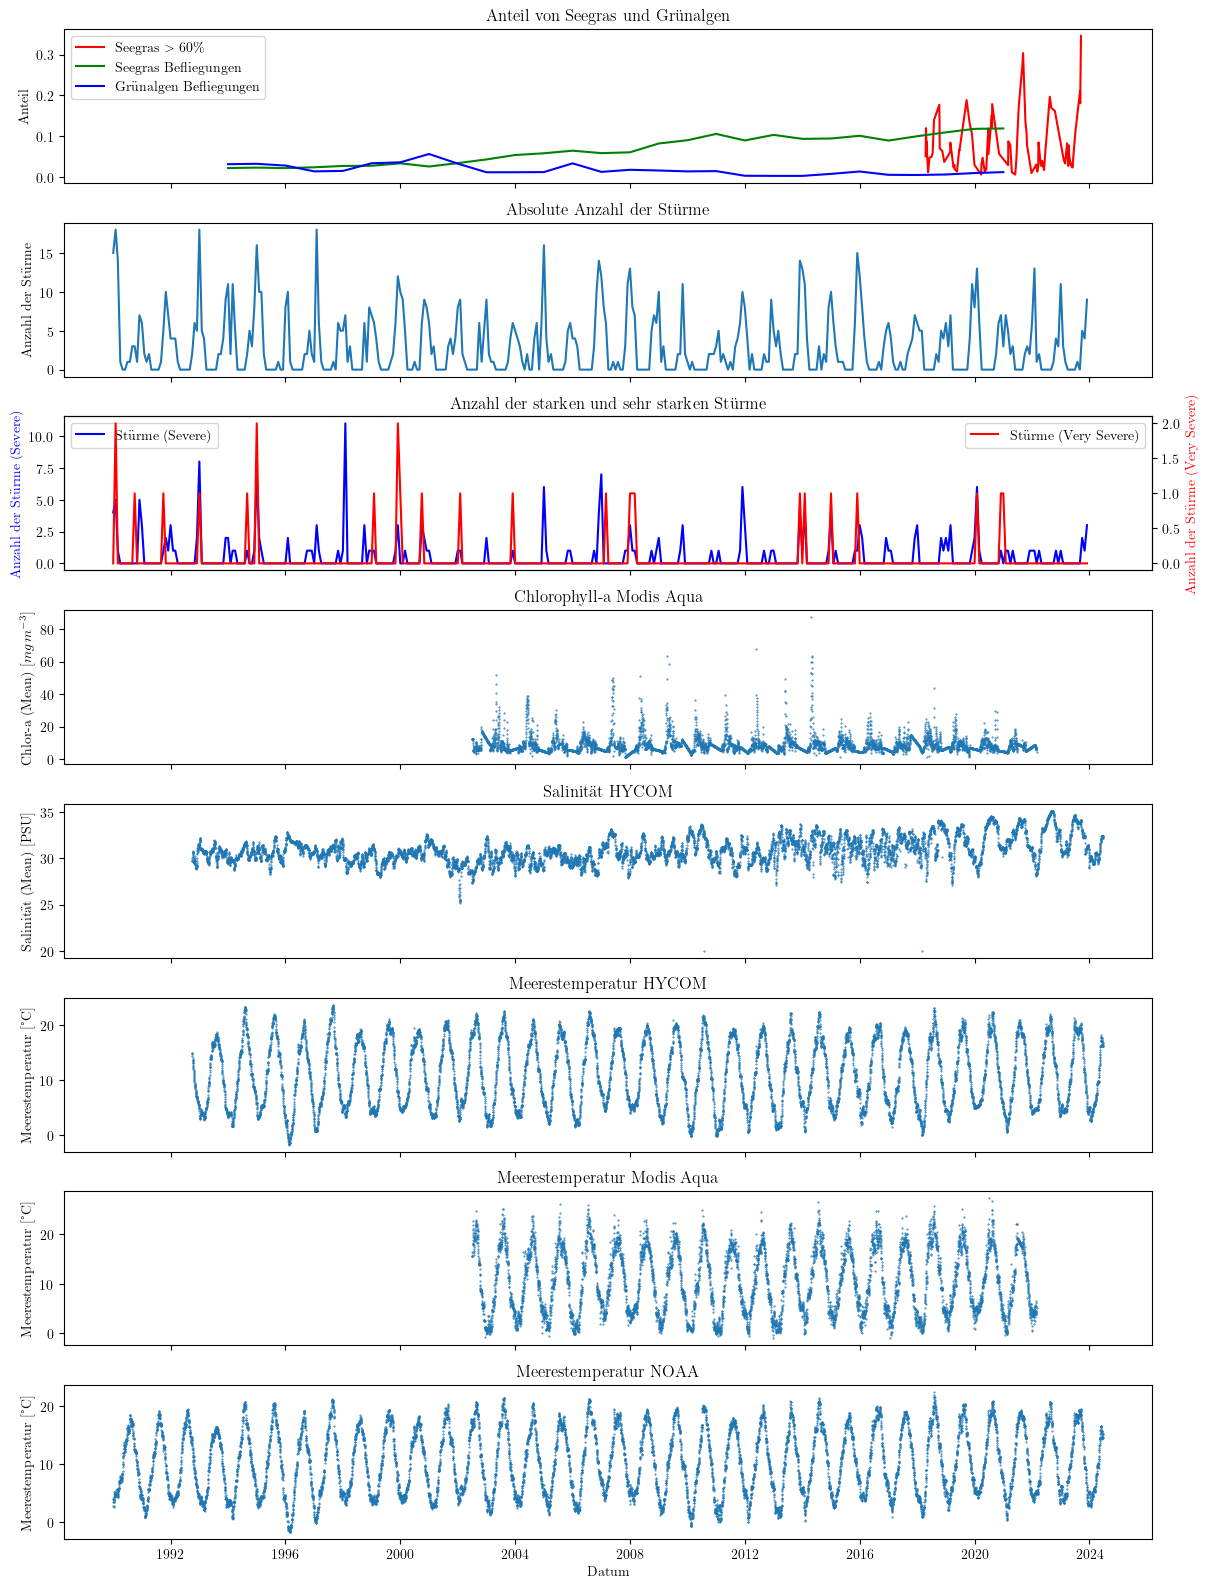

In [74]:
# long time-series
fig, axs = plt.subplots(8, 1, figsize=(12, 16), sharex=True)

axs[0].plot(df_cons['date'], df_cons['SG_all_perc'], c='red', label='Seegras $>$ 60\%')
axs[0].plot(df_sg['date'], df_sg['prop'], c='green', label='Seegras Befliegungen')
axs[0].plot(df_ga['date'], df_ga['prop'], c='blue', label='Grünalgen Befliegungen')
axs[0].set_title('Anteil von Seegras und Grünalgen')
axs[0].set_ylabel('Anteil')
axs[0].legend(loc='best')

axs[1].plot(df_storm_1['date'], df_storm_1['storms'])
axs[1].set_title('Absolute Anzahl der Stürme')
axs[1].set_ylabel('Anzahl der Stürme')

axs[2].plot(df_storm_2['date'], df_storm_2['Severe'], color='b', label='Stürme (Severe)')
axs[2].set_ylabel('Anzahl der Stürme (Severe)', c='b')
axs[2].set_title('Anzahl der starken und sehr starken Stürme')
axs[2].legend(loc='upper left')
ax2 = axs[2].twinx()
ax2.plot(df_storm_2['date'], df_storm_2['Very_Severe'], color='r', label='Stürme (Very Severe)')
ax2.set_ylabel('Anzahl der Stürme (Very Severe)', c='r')
ax2.legend(loc='upper right')

axs[3].scatter(merged_df['date'], merged_df['mean_chlor_a_y'], s=0.2)
axs[3].set_title('Chlorophyll-a Modis Aqua')
axs[3].set_ylabel('Chlor-a (Mean) [$mg\,m^{-3}$]')

axs[4].scatter(merged_df['date'], merged_df['mean_salinity'], s=0.2)
axs[4].set_title('Salinität HYCOM')
axs[4].set_ylabel('Salinität (Mean) [PSU]')

axs[5].scatter(merged_df['date'], merged_df['mean_sst_x'], s=0.2)
axs[5].set_title('Meerestemperatur HYCOM')
axs[5].set_ylabel('Meerestemperatur [°C]')

axs[6].scatter(merged_df['date'], merged_df['sst'], s=0.2)
axs[6].set_title('Meerestemperatur Modis Aqua')
axs[6].set_ylabel('Meerestemperatur [°C]')

axs[7].scatter(merged_df['date'], merged_df['mean_sst_y'], s=0.2)
axs[7].set_title('Meerestemperatur NOAA')
axs[7].set_ylabel('Meerestemperatur [°C]')
axs[7].set_xlabel('Datum')

#axs[8].plot(merged_df['date'], merged_df['mean_chlor_a_x'])
#axs[8].set_title('Chlor_A_GCOM')
#axs[8].set_ylabel('Mean Chlor_A')

#axs[9].plot(merged_df['date'], merged_df['mean_water_velocity'])
#axs[9].set_title('Water Velocity Hycom')
#axs[9].set_ylabel('Water Velocity m/s')

plt.tight_layout()
plt.savefig(r"export_path")
plt.show()

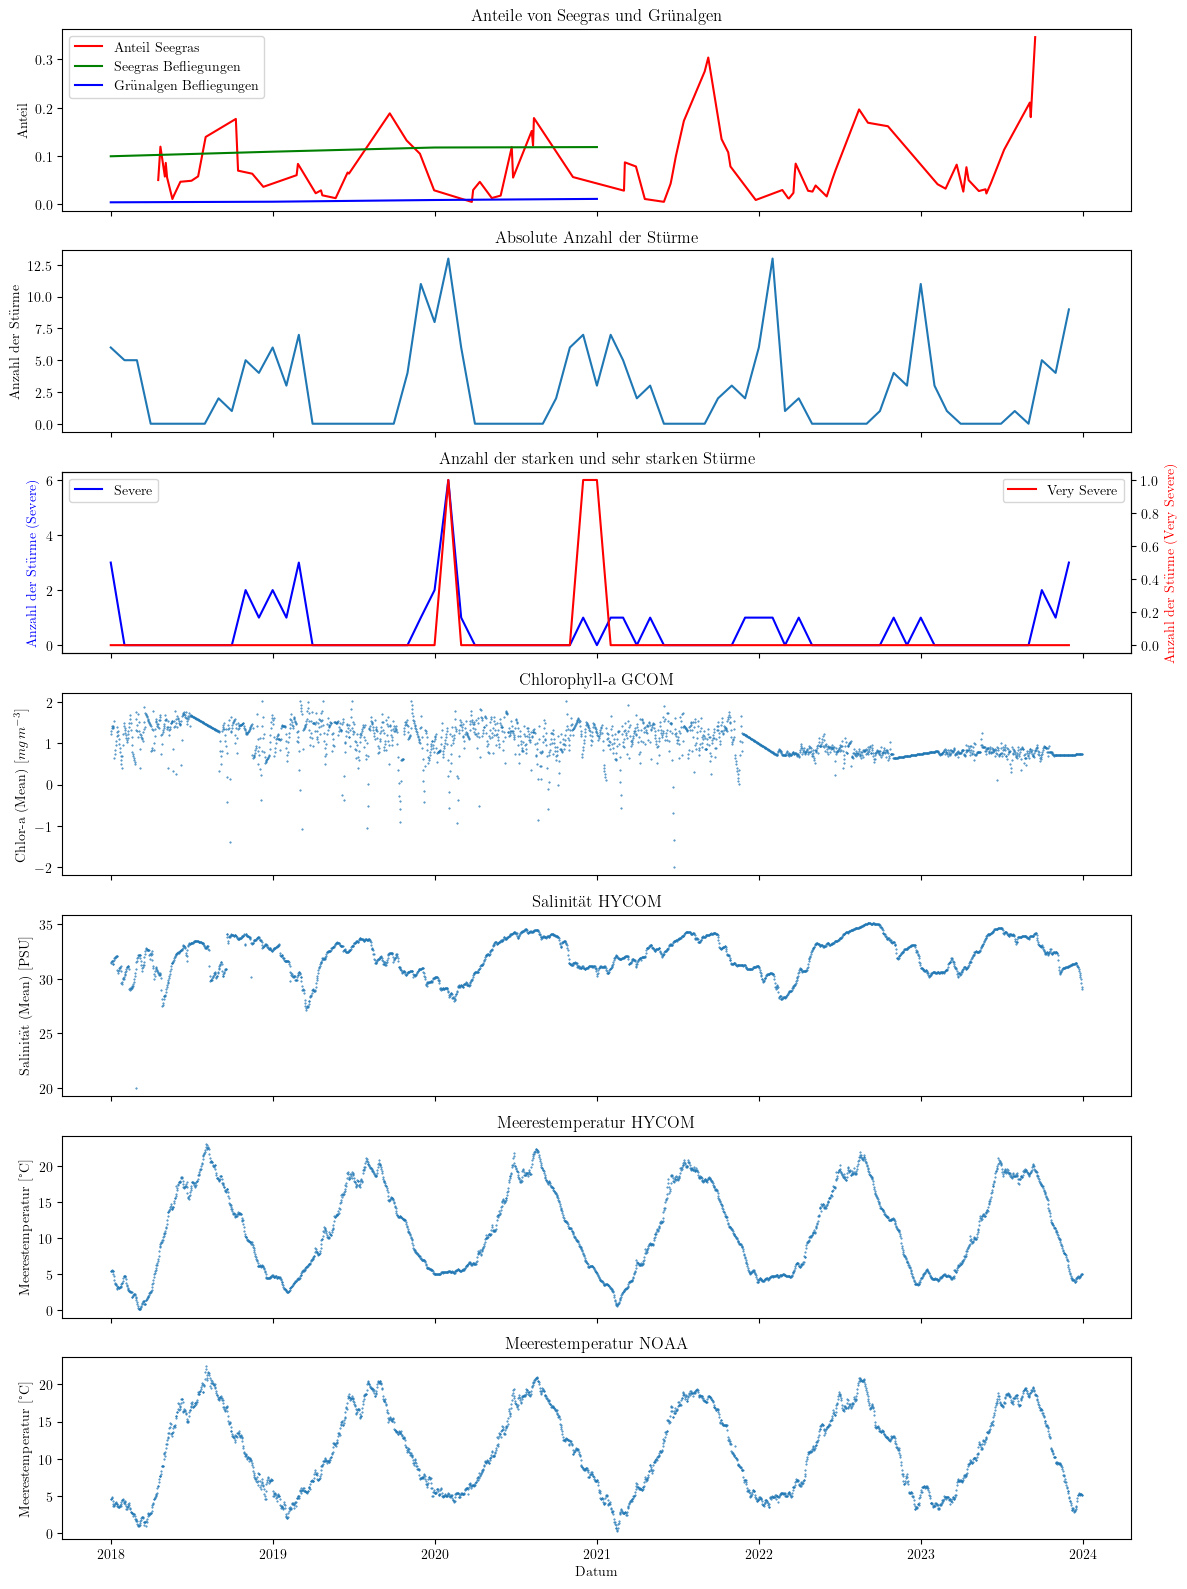

In [72]:
# short time-series
start_date = '2018-01-01'
end_date = '2023-12-31'

df_sg_filtered = df_sg[(df_sg['date'] >= start_date) & (df_sg['date'] <= end_date)]
df_ga_filtered = df_ga[(df_ga['date'] >= start_date) & (df_ga['date'] <= end_date)]
df_cons_filtered = df_cons[(df_cons['date'] >= start_date) & (df_cons['date'] <= end_date)]
df_storm_1_filtered = df_storm_1[(df_storm_1['date'] >= start_date) & (df_storm_1['date'] <= end_date)]
df_storm_2_filtered = df_storm_2[(df_storm_2['date'] >= start_date) & (df_storm_2['date'] <= end_date)]
merged_df_filtered = merged_df[(merged_df['date'] >= start_date) & (merged_df['date'] <= end_date)]

fig, axs = plt.subplots(7, 1, figsize=(12, 16), sharex=True)

axs[0].plot(df_cons_filtered['date'], df_cons_filtered['SG_all_perc'], c='red', label='Anteil Seegras')
axs[0].plot(df_sg_filtered['date'], df_sg_filtered['prop'], c='green', label='Seegras Befliegungen')
axs[0].plot(df_ga_filtered['date'], df_ga_filtered['prop'], c='blue', label='Grünalgen Befliegungen')
axs[0].set_ylabel('Anteil')
axs[0].legend(loc='best')
axs[0].set_title('Anteile von Seegras und Grünalgen')

axs[1].plot(df_storm_1_filtered['date'], df_storm_1_filtered['storms'])
axs[1].set_title('Absolute Anzahl der Stürme')
axs[1].set_ylabel('Anzahl der Stürme')

axs[2].plot(df_storm_2_filtered['date'], df_storm_2_filtered['Severe'], label='Severe', color='b')
axs[2].set_ylabel('Anzahl der Stürme (Severe)', c='b')
axs[2].set_title('Anzahl der starken und sehr starken Stürme')
axs[2].legend(loc='upper left')
ax2 = axs[2].twinx()
ax2.plot(df_storm_2_filtered['date'], df_storm_2_filtered['Very_Severe'], label='Very Severe', color='r')
ax2.set_ylabel('Anzahl der Stürme (Very Severe)', c='r')
ax2.legend(loc='upper right')

axs[3].scatter(merged_df_filtered['date'], merged_df_filtered['mean_chlor_a_x'], s=0.2)
axs[3].set_title('Chlorophyll-a GCOM')
axs[3].set_ylabel('Chlor-a (Mean) [$mg\,m^{-3}$]')

axs[4].scatter(merged_df_filtered['date'], merged_df_filtered['mean_salinity'], s=0.2)
axs[4].set_title('Salinität HYCOM')
axs[4].set_ylabel('Salinität (Mean) [PSU]')

axs[5].scatter(merged_df_filtered['date'], merged_df_filtered['mean_sst_x'], s=0.2)
axs[5].set_title('Meerestemperatur HYCOM')
axs[5].set_ylabel('Meerestemperatur [°C]')

axs[6].scatter(merged_df_filtered['date'], merged_df_filtered['mean_sst_y'], s=0.2)
axs[6].set_title('Meerestemperatur NOAA')
axs[6].set_ylabel('Meerestemperatur [°C]')
axs[6].set_xlabel('Datum')

#axs[4].plot(merged_df_filtered['date'], merged_df_filtered['mean_chlor_a_y'])
#axs[4].set_title('Chlor_A_Modis')
#axs[4].set_ylabel('Mean Chlor_A')

#axs[5].plot(merged_df_filtered['date'], merged_df_filtered['mean_water_velocity'])
#axs[5].set_title('Water Velocity Hycom')
#axs[5].set_ylabel('Water Velocity m/s')

#axs[8].plot(merged_df_filtered['date'], merged_df_filtered['sst'])
#axs[8].set_title('SST_Modis')
#axs[8].set_ylabel('Mean SST')


plt.tight_layout()
plt.savefig(r"export_path")
plt.show()